# Load Library

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, datasets
import torch.optim as optim
import torch.nn.functional as F

# Data Preprocessing

In [2]:
#Train data

#The path to save the npy file
dir_save_train_np = 'C:/Users/KDJ/Desktop/KDJ/Code/data/BCCD_Dataset_with_mask/train_np'
os.makedirs(dir_save_train_np, exist_ok=True)

#The path to the data to be preprocessed into the npy file
train_mask_paths = glob.glob('/Users/KDJ/Desktop/KDJ/Code/data/BCCD_Dataset_with_mask/train/mask/*.png')

 #The path to the data to be preprocessed into the npy file
train_original_paths = glob.glob('/Users/KDJ/Desktop/KDJ/Code/data/BCCD_Dataset_with_mask/train/original/*.png')

for i, (train_mask_path, train_original_path) in enumerate(zip(train_mask_paths, train_original_paths)):
    label_ = np.array(Image.open(train_mask_path).resize((256, 256)).convert('RGB')) #Grayscale
    input_ = np.array(Image.open(train_original_path).resize((256, 256)).convert('RGB')) #Grayscale
    np.save(os.path.join(dir_save_train_np, f'label_{i:03d}.npy'), label_)
    np.save(os.path.join(dir_save_train_np, f'input_{i:03d}.npy'), input_)


In [3]:
# Valid data

# The path to save the npy file
dir_save_val_np = 'C:/Users/KDJ/Desktop/KDJ/Code/data/BCCD_Dataset_with_mask/val_np'
os.makedirs(dir_save_val_np, exist_ok=True)

#The path to the data to be preprocessed into the npy file
val_mask_paths = glob.glob('/Users/KDJ/Desktop/KDJ/Code/data/BCCD_Dataset_with_mask/val/mask/*.png')

 #The path to the data to be preprocessed into the npy file
val_original_paths = glob.glob('/Users/KDJ/Desktop/KDJ/Code/data/BCCD_Dataset_with_mask/val/original/*.png')

for i, (val_mask_path, val_original_path) in enumerate(zip(val_mask_paths, val_original_paths)):
    label_ = np.array(Image.open(val_mask_path).resize((256, 256)).convert('RGB')) #Grayscale
    input_ = np.array(Image.open(val_original_path).resize((256, 256)).convert('RGB')) #Grayscale
    np.save(os.path.join(dir_save_val_np, f'label_{i:03d}.npy'), label_)
    np.save(os.path.join(dir_save_val_np, f'input_{i:03d}.npy'), input_)


In [4]:
# Test data

#The path to save the npy file
dir_save_test_np = 'C:/Users/KDJ/Desktop/KDJ/Code/data/BCCD_Dataset_with_mask/test_np'
os.makedirs(dir_save_test_np, exist_ok=True)

#The path to the data to be preprocessed into the npy file
test_mask_paths = glob.glob('/Users/KDJ/Desktop/KDJ/Code/data/BCCD_Dataset_with_mask/test/mask/*.png')

 #The path to the data to be preprocessed into the npy file
test_original_paths = glob.glob('/Users/KDJ/Desktop/KDJ/Code/data/BCCD_Dataset_with_mask/test/original/*.png')

for i, (test_mask_path, test_original_path) in enumerate(zip(test_mask_paths, test_original_paths)):
    label_ = np.array(Image.open(test_mask_path).resize((256, 256)).convert('RGB')) #Grayscale
    input_ = np.array(Image.open(test_original_path).resize((256, 256)).convert('RGB')) #Grayscale
    np.save(os.path.join(dir_save_test_np, f'label_{i:03d}.npy'), label_)
    np.save(os.path.join(dir_save_test_np, f'input_{i:03d}.npy'), input_)


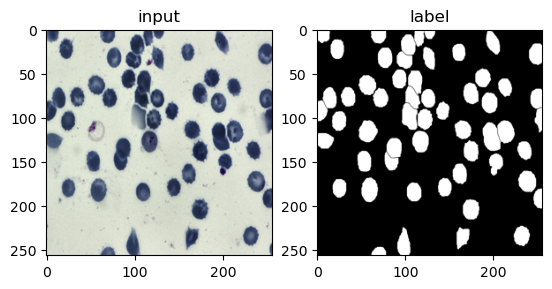

(256, 256, 3)
(256, 256, 3)


In [5]:
## 이미지 시각화
plt.subplot(122)
plt.imshow(label_, cmap='gray')
plt.title('label')

plt.subplot(121)
plt.imshow(input_, cmap='gray')
plt.title('input')

plt.show()

print(np.shape(label_))
print(np.shape(input_))

# Network

In [6]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Convolution + BatchNormalization + Relu
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True): 
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path
        self.enc1_1 = CBR2d(in_channels=3, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # Expansive path
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    # forward
    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x


In [7]:
# state_dict 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet().to(device)
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

Model's state_dict:
enc1_1.0.weight 	 torch.Size([64, 3, 3, 3])
enc1_1.0.bias 	 torch.Size([64])
enc1_1.1.weight 	 torch.Size([64])
enc1_1.1.bias 	 torch.Size([64])
enc1_1.1.running_mean 	 torch.Size([64])
enc1_1.1.running_var 	 torch.Size([64])
enc1_1.1.num_batches_tracked 	 torch.Size([])
enc1_2.0.weight 	 torch.Size([64, 64, 3, 3])
enc1_2.0.bias 	 torch.Size([64])
enc1_2.1.weight 	 torch.Size([64])
enc1_2.1.bias 	 torch.Size([64])
enc1_2.1.running_mean 	 torch.Size([64])
enc1_2.1.running_var 	 torch.Size([64])
enc1_2.1.num_batches_tracked 	 torch.Size([])
enc2_1.0.weight 	 torch.Size([128, 64, 3, 3])
enc2_1.0.bias 	 torch.Size([128])
enc2_1.1.weight 	 torch.Size([128])
enc2_1.1.bias 	 torch.Size([128])
enc2_1.1.running_mean 	 torch.Size([128])
enc2_1.1.running_var 	 torch.Size([128])
enc2_1.1.num_batches_tracked 	 torch.Size([])
enc2_2.0.weight 	 torch.Size([128, 128, 3, 3])
enc2_2.0.bias 	 torch.Size([128])
enc2_2.1.weight 	 torch.Size([128])
enc2_2.1.bias 	 torch.Size([128])
enc2_

# DataLoader 

In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        lst_data = os.listdir(self.data_dir)

        lst_label = [f for f in lst_data if f.startswith('label')]
        lst_input = [f for f in lst_data if f.startswith('input')]

        lst_label.sort()
        lst_input.sort()

        self.lst_label = lst_label
        self.lst_input = lst_input

    def __len__(self):
        return len(self.lst_label)

    def __getitem__(self, index):
        label = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        input = np.load(os.path.join(self.data_dir, self.lst_input[index]))

        # Normalization
        label = label/255.0
        input = input/255.0

        # Create a new channel (axis) if dimension of image and label = 2 (no channel, black and white image)
        if label.ndim == 2:
            label = label[:, :, np.newaxis]
        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        # # if label is 3 channels, change to 1 channel
        if label.shape[2] == 3:
            label = label[:, :, :1]
        
        data = {'input': input, 'label': label}

        # If transform is defined, fetch data that has been transformed
        if self.transform:
            data = self.transform(data)

        return data

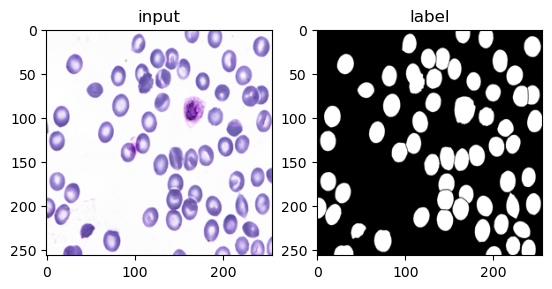

In [9]:
# Check that the dataloader is well implemented

dataset_train = Dataset(data_dir=dir_save_train_np)
data = dataset_train.__getitem__(0) # load a single image
input = data['input']
label = data['label']

plt.subplot(122)
plt.imshow(label.reshape(256,256), cmap='gray')
plt.title('label')

plt.subplot(121)
plt.imshow(input.reshape(256,256,3), cmap='gray')
plt.title('input')

plt.show()

# Transform

In [10]:

class ToTensor(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        label = label.transpose((2, 0, 1)).astype(np.float32)
        input = input.transpose((2, 0, 1)).astype(np.float32)

        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}

        return data

class Normalization(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - self.mean) / self.std

        data = {'label': label, 'input': input}

        return data

class RandomFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)

        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)

        data = {'label': label, 'input': input}

        return data
    
class RandomHorizontalFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)

        data = {'label': label, 'input': input}

        return data

class RandomVerticalFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)

        data = {'label': label, 'input': input}

        return data

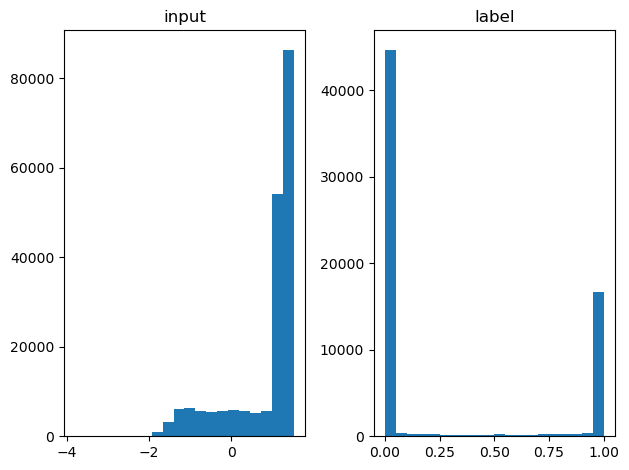

In [11]:
# Check if transform is implemented well
transform = transforms.Compose([Normalization(mean=(0.72465917, 0.71948726, 0.76607353), std=(0.21150185, 0.22043237, 0.15324079)), RandomFlip(), ToTensor()])
dataset_train = Dataset(data_dir=dir_save_train_np, transform=transform)
data = dataset_train.__getitem__(0) # load a single image
input = data['input']
label = data['label']

plt.subplot(122)
plt.hist(label.flatten(), bins=20)
plt.title('label')

plt.subplot(121)
plt.hist(input.flatten(), bins=20)
plt.title('input')

plt.tight_layout()
plt.show()

# Define network Save / Load functions

In [12]:
# Save netw
def save(ckpt_dir, net, optim, epoch, best=False):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    if best:
        torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
                   "%s/model_best_Unet_RGB.pth" % ckpt_dir)
    # else:
    #     torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
    #                "%s/model_epoch%d.pth" % (ckpt_dir, epoch))


# Load net
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst = [f for f in ckpt_lst if f.endswith(".pth")]
    ckpt_lst = sorted(ckpt_lst, key=lambda f: int(''.join(filter(str.isdigit, f.split(".")[0]))) if f.split(".")[0].isdigit() else -1)

    if not ckpt_lst:
        epoch = 0
        return net, optim, epoch

    dict_model = torch.load(os.path.join(ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    
    try:
        epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])
    except IndexError:
        epoch = 0

    return net, optim, epoch

# Define IoU metrics

In [13]:
def calculate_iou(prediction, ground_truth):
    prediction = prediction.cpu().numpy()  # Move a CUDA tensor to the CPU and convert it to a NumPy array
    ground_truth = ground_truth.cpu().numpy()  # Move a CUDA tensor to the CPU and convert it to a NumPy array
    
    intersection = np.logical_and(prediction, ground_truth)
    union = np.logical_or(prediction, ground_truth)
    iou = np.sum(intersection) / np.sum(union)
    return iou

# Set training

In [14]:
# Set training parameters
lr = 1e-4
batch_size = 4
num_epoch = 2

base_dir = r'C:\Users\KDJ\Desktop\KDJ\Code'
data_dir = r"C:\Users\KDJ\Desktop\KDJ\Code\data\BCCD_Dataset_with_mask"
ckpt_dir = os.path.join(base_dir, "checkpoint")
log_dir = os.path.join(base_dir, "log")
os.makedirs(ckpt_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

# Transform
transform = transforms.Compose([
    Normalization((0.72465917, 0.71948726, 0.76607353), std=(0.21150185, 0.22043237, 0.15324079)),
    RandomHorizontalFlip(),  # Randomly flip left and right
    RandomVerticalFlip(),   # Randomly flip up and down
    RandomFlip(),
    ToTensor(), 
])

# DataLoader
dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train_np'), transform=transform)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)

dataset_val = Dataset(data_dir=os.path.join(data_dir, 'val_np'), transform=transform)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=0)

# Create Network
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet().to(device)

# Define loss function
fn_loss = nn.BCEWithLogitsLoss().to(device)

# Set Optimizer
optim = torch.optim.Adam(net.parameters(), lr=lr)

# # Set other ancillary variables
num_data_train = len(dataset_train)
num_data_val = len(dataset_val)

num_batch_train = np.ceil(num_data_train / batch_size)
num_batch_val = np.ceil(num_data_val / batch_size)

# # Set other ancillary functions
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: 1.0 * (x > 0.5)

# Set up a SummaryWriter to use Tensorboard
writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir=os.path.join(log_dir, 'val'))

# Load the trained model, if any
st_epoch = 0
net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim) 

best_loss = float('inf')


# Training

In [ ]:

for epoch in range(st_epoch + 1, num_epoch + 1):
        net.train()
        loss_arr = []
        iou_arr = []

        for batch, data in enumerate(loader_train, 1):
            # forward pass
            label = data['label'].to(device)
            input = data['input'].to(device)

            output = net(input)

            # backward pass
            optim.zero_grad()

            loss = fn_loss(output, label)
            loss.backward()

            optim.step()

            # Calculate the loss function
            loss_arr += [loss.item()]

            # Calculate the IoU
            prediction = fn_class(output)
            iou = calculate_iou(prediction, label)
            iou_arr += [iou]

            print("TRAIN: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f | IOU %.4f" %
                    (epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr), np.mean(iou_arr)))
            
            # Save Tensorboard
            label = fn_tonumpy(label)
            input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
            output = fn_tonumpy(fn_class(output))

            writer_train.add_image('label', label, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
            writer_train.add_image('input', input, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
            writer_train.add_image('output', output, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')

        writer_train.add_scalar('loss_Unet_RGB', np.mean(loss_arr), epoch)
        writer_train.add_scalar('iou_Unet_RGB', np.mean(iou_arr), epoch)

        with torch.no_grad():
            net.eval()
            loss_arr = []
            iou_arr = []

            for batch, data in enumerate(loader_val, 1):
                # forward pass
                label = data['label'].to(device)
                input = data['input'].to(device)

                output = net(input)

                # Calculate the loss function
                loss = fn_loss(output, label)

                loss_arr += [loss.item()]

                # Calculate the IoU
                prediction = fn_class(output)
                iou = calculate_iou(prediction, label)
                iou_arr += [iou]

                print("VAILD: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f | IOU %.4f" %
                    (epoch, num_epoch, batch, num_batch_val, np.mean(loss_arr), np.mean(iou_arr)))
            
                # Save Tensorboard
                label = fn_tonumpy(label)
                input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
                output = fn_tonumpy(fn_class(output))

                writer_val.add_image('label', label, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
                writer_val.add_image('input', input, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
                writer_val.add_image('output', output, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')

        writer_val.add_scalar('loss_Unet_RGB', np.mean(loss_arr), epoch)
        writer_val.add_scalar('iou_Unet_RGB', np.mean(iou_arr), epoch)

        mean_loss = np.mean(loss_arr)

        # Save only the best model
        if mean_loss < best_loss:
            best_loss = mean_loss
            save(ckpt_dir=ckpt_dir, net=net, optim=optim, epoch=epoch, best=True)
        else:
            save(ckpt_dir=ckpt_dir, net=net, optim=optim, epoch=epoch, best=False)

        writer_train.close()
        writer_val.close()


# View the graph with Tensorboard


In [40]:
#View the graph with Tensorboard
!tensorboard --logdir ./log 

^C


# Model test

In [ ]:
transform = transforms.Compose([Normalization((0.72465917, 0.71948726, 0.76607353), std=(0.21150185, 0.22043237, 0.15324079)), ToTensor()])
dataset_test = Dataset(data_dir=os.path.join(data_dir, 'test_np'), transform=transform)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=0)
print(os.path.join(data_dir, 'test'))
print(len(loader_test))
print(len(dataset_test))
num_data_test = len(dataset_test)
num_batch_test = np.ceil(num_data_test / batch_size)

result_dir = os.path.join(base_dir, 'result')
if not os.path.exists(result_dir):
    os.makedirs(os.path.join(result_dir, 'png'))
    os.makedirs(os.path.join(result_dir, 'numpy'))


net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

with torch.no_grad():
      net.eval()
      loss_arr = []

      for batch, data in enumerate(loader_test, 1):

          label = data['label'].to(device)
          input = data['input'].to(device)

          output = net(input)
          
          loss = fn_loss(output, label)

          loss_arr += [loss.item()]

          print("TEST: BATCH %04d / %04d | LOSS %.4f" %
                (batch, num_batch_test, np.mean(loss_arr)))
          
          label = fn_tonumpy(label)
          input = fn_tonumpy(fn_denorm(input, mean=(0.5), std=(0.5)))
          output = fn_tonumpy(fn_class(output))

          for j in range(label.shape[0]):
              id = num_batch_test * (batch - 1) + j
              # 이미지 값을 0에서 1 사이의 부동 소수점에서 0에서 255 사이의 정수로 변환
              input_image = (input[j].squeeze() * 255).astype(np.uint8)
              plt.imsave(os.path.join(result_dir, 'png', 'input_%04d.png' % id), input_image, cmap='gray')
              plt.imsave(os.path.join(result_dir, 'png', 'label_%04d.png' % id), label[j].squeeze(), cmap='gray')
              plt.imsave(os.path.join(result_dir, 'png', 'output_%04d.png' % id), output[j].squeeze(), cmap='gray')

              np.save(os.path.join(result_dir, 'numpy', 'label_%04d.npy' % id), label[j].squeeze())
              np.save(os.path.join(result_dir, 'numpy', 'input_%04d.npy' % id), input[j].squeeze())
              np.save(os.path.join(result_dir, 'numpy', 'output_%04d.npy' % id), output[j].squeeze())

print("AVERAGE TEST: BATCH %04d / %04d | LOSS %.4f" %
        (batch, num_batch_test, np.mean(loss_arr)))

# Visualizing the results

In [ ]:
for i in range(10):
    ##
    lst_data = os.listdir(os.path.join(result_dir, 'numpy'))

    lst_label = [f for f in lst_data if f.startswith('label')]
    lst_input = [f for f in lst_data if f.startswith('input')]
    lst_output = [f for f in lst_data if f.startswith('output')]

    lst_label.sort()
    lst_input.sort()
    lst_output.sort()

    ##
    id = i

    label = np.load(os.path.join(result_dir,"numpy", lst_label[id]))
    input = np.load(os.path.join(result_dir,"numpy", lst_input[id]))
    output = np.load(os.path.join(result_dir,"numpy", lst_output[id]))

    ##
    plt.figure(figsize=(8,6))
    plt.subplot(131)
    plt.imshow(input, cmap='gray')
    plt.title('input')

    plt.subplot(132)
    plt.imshow(label, cmap='gray')
    plt.title('label')

    plt.subplot(133)
    plt.imshow(output, cmap='gray')
    plt.title('output')

    plt.show()


# Inference

In [ ]:

infer_data_paths = glob.glob('path/*png')

dir_save_infer_np = 'path/infer_np'

if not os.path.exists(dir_save_infer_np):
    os.makedirs(dir_save_infer_np)

for i, infer_data_path in enumerate(infer_data_paths):
    infer_data = np.array(Image.open(infer_data_path).resize((256, 256)).convert('L'))
    input_ = np.asarray(infer_data)
    np.save(os.path.join(dir_save_infer_np, 'input_%03d.npy' % i), input_)


In [ ]:
class Dataset_infer(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        lst_data = os.listdir(self.data_dir)

        lst_input = [f for f in lst_data if f.startswith('input')]

        lst_input.sort()

        self.lst_input = lst_input

    def __len__(self):
        return len(self.lst_input)

    def __getitem__(self, index):
        input = np.load(os.path.join(self.data_dir, self.lst_input[index]))

        input = input/255.0

        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        data = {'input': input}

        if self.transform:
            data = self.transform(data)

        return data
    
class ToTensor_infer(object):
    def __call__(self, data):
        input = data['input']

        input = input.transpose((2, 0, 1)).astype(np.float32)

        data = {'input': torch.from_numpy(input)}

        return data

class Normalization_infer:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        input = data['input']
        input = (input - self.mean) / self.std
        data = {'input': input}
        return data

In [ ]:
base_dir = r'path'
infer_base_dir = r'path'
infer_data_dir = r"path"
ckpt_dir = os.path.join(base_dir, "checkpoint")

transform = transforms.Compose([Normalization_infer(mean=0.5, std=0.5), ToTensor_infer()])

dataset_test = Dataset_infer(data_dir=os.path.join(infer_data_dir, 'infer_np'), transform=transform)
loader_test = DataLoader(dataset_test, batch_size=8, shuffle=False, num_workers=0)

num_data_test = len(dataset_test)
num_batch_test = np.ceil(num_data_test / batch_size)

result_dir = os.path.join(infer_base_dir, 'result')
if not os.path.exists(result_dir):
    os.makedirs(os.path.join(result_dir, 'png'))
    os.makedirs(os.path.join(result_dir, 'numpy'))

net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

with torch.no_grad():
    net.eval()

    num = 1
    
    for batch, data in enumerate(loader_test, 1):

        input = data['input'].to(device)

        output = net(input)

        input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
        output = fn_tonumpy(fn_class(output))

        for j in range(input.shape[0]):
            id = num
            num += 1
            plt.imsave(os.path.join(result_dir, 'png', 'input_%04d.png' % id), input[j].squeeze(), cmap='gray')
            plt.imsave(os.path.join(result_dir, 'png', 'output_%04d.png' % id), output[j].squeeze(), cmap='gray')

            np.save(os.path.join(result_dir, 'numpy', 'input_%04d.npy' % id), input[j].squeeze())
            np.save(os.path.join(result_dir, 'numpy', 'output_%04d.npy' % id), output[j].squeeze())


In [ ]:
for i in range(10):
    ##
    lst_data = os.listdir(os.path.join(result_dir, 'numpy'))

    lst_input = [f for f in lst_data if f.startswith('input')]
    lst_output = [f for f in lst_data if f.startswith('output')]

    lst_input.sort()
    lst_output.sort()

    ##
    id = i

    input = np.load(os.path.join(result_dir,"numpy", lst_input[id]))
    output = np.load(os.path.join(result_dir,"numpy", lst_output[id]))

    ##
    plt.figure(figsize=(8,6))
    plt.subplot(131)
    plt.imshow(input, cmap='gray')
    plt.title('input')

    plt.subplot(132)
    plt.imshow(output, cmap='gray')
    plt.title('output')

    plt.show()
